In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
data_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/output/psf_dataset/'
wf_psf_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/wf-psf/'

# SED folder path
SED_path = wf_psf_dir+'data/SEDs/save_SEDs/'

# Load the datasets
dataset_gt_train = np.load(data_dir + 'train_12000_stars_id_002_8bins.npy', allow_pickle=True)[()]
print(dataset_gt_train.keys())
dataset_gt_test = np.load(data_dir + 'test_1000_stars_id_002_8bins.npy', allow_pickle=True)[()]

dict_keys(['stars', 'noisy_stars', 'mono_psfs', 'positions', 'SEDs', 'packed_SEDs', 'zernike_coef', 'C_poly', 'parameters', 'SED_ids', 'SNR'])


# Train with the approximated dataset

In [4]:
n_stars_list = [50, 100]
# Load the datasets
datasets_train = [np.load(data_dir + 'train_12000_stars_id_002_8bins_approx_{}_stars.npy'.format(n_stars), allow_pickle=True)[()] for n_stars in n_stars_list]
datasets_test = [np.load(data_dir + 'test_1000_stars_id_002_8bins_approx_{}_stars.npy'.format(n_stars), allow_pickle=True)[()] for n_stars in n_stars_list]


In [5]:
noisy = True
if noisy == True:
    obs_type = 'noisy_stars'
else:
    obs_type = 'stars'
test_star_offset = 2000
train_star_offset = 4000
diff_train_list = []
diff_test_list = []
y_train_list = []
y_test_list = []

# Compute the star spectral energy distribution estimation for each dataset
for dataset_train, dataset_test in zip(datasets_train, datasets_test):
    diff_train = []
    for i in range(train_star_offset, dataset_train['parameters']['n_stars']):
        diff = (np.array([np.sum((mono_psf-dataset_gt_train[obs_type][i])**2) for mono_psf in dataset_train['mono_psfs_approx'][i]]))
        diff_train.append((1-diff)/np.sum(1-diff))
    diff_train_list.append( np.array(diff_train) )
    y_train_list.append( dataset_train['SED_ids'][train_star_offset:])

    # diff_test = []
    # for i in range(dataset_test['parameters']['n_stars']):
    #     diff = (np.array([np.sum((mono_psf-dataset_gt_test[obs_type][i])**2) for mono_psf in dataset_test['mono_psfs_approx'][i]]))
    #     diff_test.append((1-diff)/np.sum(1-diff))
    # diff_test_list.append( np.array(diff_test) )
    # y_test_list.append( dataset_test['SED_ids'])
    diff_test = []
    for i in range(test_star_offset, train_star_offset):
        diff = (np.array([np.sum((mono_psf-dataset_gt_train[obs_type][i])**2) for mono_psf in dataset_train['mono_psfs_approx'][i]]))
        diff_test.append((1-diff)/np.sum(1-diff))
    diff_test_list.append( np.array(diff_test) )
    y_test_list.append( dataset_train['SED_ids'][test_star_offset:train_star_offset])


In [6]:
print(len(diff_train_list), 'datasets for x train with shape:', diff_train_list[0].shape)
print(len(y_train_list), 'datasets for y train with shape:', len(y_train_list[0]))
print(len(diff_test_list), 'datasets for x test with shape:', diff_test_list[0].shape)
print(len(y_test_list), 'datasets for y test with shape:', len(y_test_list[0]))


2 datasets for x train with shape: (8000, 8)
2 datasets for y train with shape: 8000
2 datasets for x test with shape: (2000, 8)
2 datasets for y test with shape: 2000


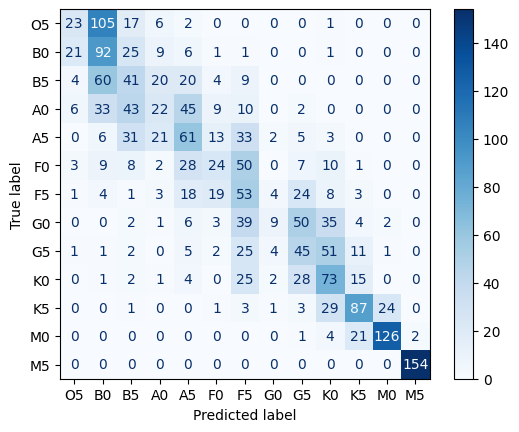

n_stars_train:  50
Accuracy:  0.405
Top-2 accuracy:  0.7635
---------------------------------
prediction confidence: 0.21785906383832435
prediction confidence relaxed: 0.5629169155444164
missed prediction probability: 0.10648293069821209
missed prediction probability relaxed: 0.022945190321878885


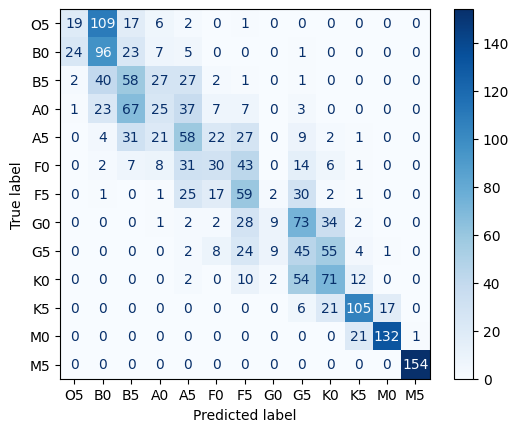

n_stars_train:  100
Accuracy:  0.4305
Top-2 accuracy:  0.8075
---------------------------------
prediction confidence: 0.2542205109907695
prediction confidence relaxed: 0.6334353355530181
missed prediction probability: 0.11416368699431707
missed prediction probability relaxed: 0.020931698970634637


In [7]:
star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']
rand_runs = 1

rnd_cm_list = []
rnd_accuracy_list = []
rnd_relaxed_accuracy_list = []
rnd_confidence_list = []
rnd_confidence_relaxed_list = []
rnd_p_miss_list = []
rnd_p_miss_relaxed_list = []

predictions_list = []
star_index_list = []

for run in range(rand_runs):

    cm_list = []
    accuracy_list = []
    relaxed_accuracy_list = []
    confidence_list = []
    confidence_relaxed_list = []
    p_miss_list = []
    p_miss_relaxed_list = []

    for diff_train, y_train, diff_test, y_test, n_stars in zip(diff_train_list, y_train_list, diff_test_list, y_test_list ,n_stars_list):
        
        # # Shuffle train and test datasets
        # diff_train_test = np.concatenate((diff_train,diff_test))
        # y_train_test = np.concatenate((y_train,y_test))
        # randomize = np.arange(len(diff_train_test))
        # np.random.shuffle(randomize)
        # diff_train_test_rnd = diff_train_test[randomize]
        # y_train_test_rnd = np.array(y_train_test)[randomize]
        # # Split the dataset into train and test
        # diff_train = diff_train_test_rnd[:diff_train.shape[0]]
        # y_train = y_train_test_rnd[:diff_train.shape[0]]
        # diff_test = diff_train_test_rnd[diff_train.shape[0]:]
        # y_test = y_train_test_rnd[diff_train.shape[0]:]
        
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
        clf.fit(diff_train, y_train)
        predictions = clf.predict(diff_test)
        predictions_proba = clf.predict_proba(diff_test)

        # Save the predicted SEDs
        predictions_list.append(predictions)
        # star_index_list.append(randomize)

        cm = confusion_matrix(y_test, predictions)
        cm_list.append(cm)
        if run == rand_runs-1:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=star_class_labels)
            disp.plot(cmap=plt.cm.Blues)
            plt.show()

        accuracy = np.trace(cm)/np.sum(cm)
        relaxed_accuracy = (np.trace(cm, offset=1) + np.trace(cm, offset=-1) + np.trace(cm) )/np.sum(cm)
        accuracy_list.append(accuracy)
        relaxed_accuracy_list.append(relaxed_accuracy)
        if run == rand_runs-1:
            print('n_stars_train: ', n_stars)
            print('Accuracy: ', accuracy)
            print('Top-2 accuracy: ', relaxed_accuracy)
            print('---------------------------------')
        
        p_tot = 0
        p_tot_relaxed = 0
        p_miss_tot = 0
        p_miss_tot_relaxed = 0

        for pred_proba, k in zip(predictions_proba, y_test):
            if np.abs(np.argmax(pred_proba) - k) <= 1:
                if k == 0:
                    p_tot_relaxed += pred_proba[k] + pred_proba[k+1]
                elif k == 12:
                    p_tot_relaxed += pred_proba[k] + pred_proba[k-1]
                else:
                    p_tot_relaxed += pred_proba[k] + pred_proba[k-1] + pred_proba[k+1]
            if k == np.argmax(pred_proba):
                p_tot += pred_proba[k]
            if k != np.argmax(pred_proba):
                p_miss_tot += pred_proba[k]
            if np.abs(np.argmax(pred_proba) - k) >= 2:
                p_miss_tot_relaxed += pred_proba[k]


        confidence_list.append(p_tot/len(predictions_proba))
        confidence_relaxed_list.append(p_tot_relaxed/len(predictions_proba))
        p_miss_list.append(p_miss_tot/len(predictions_proba))
        p_miss_relaxed_list.append(p_miss_tot_relaxed/len(predictions_proba))

        if run == rand_runs-1:
            print('prediction confidence:', p_tot/len(predictions_proba))
            print('prediction confidence relaxed:',p_tot_relaxed/len(predictions_proba))
            print('missed prediction probability:', p_miss_tot/len(predictions_proba))
            print('missed prediction probability relaxed:', p_miss_tot_relaxed/len(predictions_proba))

    rnd_cm_list.append(cm_list)
    rnd_accuracy_list.append(accuracy_list)
    rnd_relaxed_accuracy_list.append(relaxed_accuracy_list)
    rnd_confidence_list.append(confidence_list)
    rnd_confidence_relaxed_list.append(confidence_relaxed_list)
    rnd_p_miss_list.append(p_miss_list)
    rnd_p_miss_relaxed_list.append(p_miss_relaxed_list)



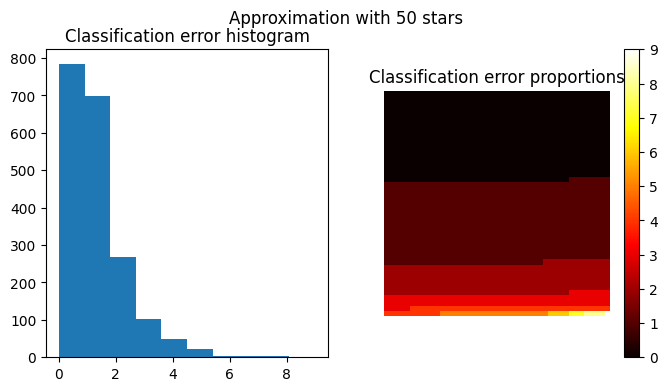

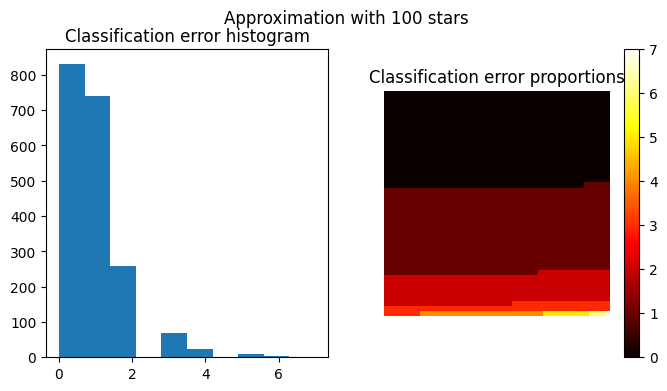

In [8]:
for i in range(2):
    y_mat = np.array(y_test_list[i][:44**2]).reshape(44,44) 
    pred_mat = np.array(predictions_list[i][:44**2]).reshape(44,44)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.hist(np.sort(np.abs(y_mat.reshape(-1) - pred_mat.reshape(-1))))
    plt.title('Classification error histogram')
    plt.subplot(1,2,2)
    plt.imshow(np.sort(np.abs(y_mat.reshape(-1) - pred_mat.reshape(-1))).reshape(44,44), cmap='hot')
    plt.title('Classification error proportions')
    plt.suptitle('Approximation with {} stars'.format(n_stars_list[i]))
    plt.colorbar()
    plt.axis('off')


# Concatenate predictions to datasets

In [24]:
# Paths
wf_psf_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/wf-psf/'
SED_path = wf_psf_dir+'data/SEDs/save_SEDs/'
output_path = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/notebooks/concat_dataset_preds/output/'

# Load the SEDs
stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)


In [25]:
# Load the PSF training datasets
extra_dataset = np.load(data_dir + 'train_12000_stars_id_002_8bins.npy', allow_pickle=True)[()]

for n_stars, preds in zip(n_stars_list, predictions_list):

    base_dataset = np.load(data_dir + 'train_{}_stars_id_002_8bins.npy'.format(n_stars), allow_pickle=True)[()]

    # Save the predicted SEDs
    SED_list = []
    for spectral_class in preds:
        concat_SED_wv = np.concatenate((
            stellar_lambdas.reshape(-1,1),
            stellar_SEDs[spectral_class,:].reshape(-1,1)), axis=1)
        SED_list.append(concat_SED_wv)
    SED_array = np.array(SED_list)
    SED_array.shape

    extra_sizes = [50, 100, 200, 500, 1000, 2000]
    extra_dataset_offset = 2000
    for size in extra_sizes:
        dataset_concat = {
                'stars': np.concatenate((base_dataset['stars'], extra_dataset['stars'][extra_dataset_offset:extra_dataset_offset+size]), axis=0 ),
                'noisy_stars': np.concatenate((base_dataset['noisy_stars'], extra_dataset['noisy_stars'][extra_dataset_offset:extra_dataset_offset+size]), axis=0 ),
                'mono_psfs': np.concatenate((base_dataset['mono_psfs'], extra_dataset['mono_psfs'][extra_dataset_offset:extra_dataset_offset+size]), axis=0 ),
                'positions': np.concatenate((base_dataset['positions'], extra_dataset['positions'][extra_dataset_offset:extra_dataset_offset+size]), axis=0 ),

                'SEDs': np.concatenate((base_dataset['SEDs'], SED_array[:size]), axis=0 ),
                'SED_ids': np.concatenate((base_dataset['SED_ids'], preds[:size]), axis=0 ),
                
                'zernike_coef': np.concatenate((base_dataset['zernike_coef'], extra_dataset['zernike_coef'][extra_dataset_offset:extra_dataset_offset+size]), axis=0 ),
                'C_poly': base_dataset['C_poly'],
                'parameters': base_dataset['parameters'],
                'SNR': np.concatenate((base_dataset['SNR'], extra_dataset['SNR'][extra_dataset_offset:extra_dataset_offset+size]), axis=0 ),
                
            }
        dataset_concat['parameters']['n_stars']=n_stars+size

        # Save the dataset
        np.save(output_path + 'train_{}_stars_id_002_8bins_plus_{}_stars.npy'.format(n_stars, size), dataset_concat, allow_pickle=True)
        print('Base dataset with {} stars and extra {} stars saved'.format(n_stars, size))

Base dataset with 50 stars and extra 50 stars saved
Base dataset with 50 stars and extra 100 stars saved
Base dataset with 50 stars and extra 200 stars saved
Base dataset with 50 stars and extra 500 stars saved
Base dataset with 50 stars and extra 1000 stars saved
Base dataset with 50 stars and extra 2000 stars saved
Base dataset with 100 stars and extra 50 stars saved
Base dataset with 100 stars and extra 100 stars saved
Base dataset with 100 stars and extra 200 stars saved
Base dataset with 100 stars and extra 500 stars saved
Base dataset with 100 stars and extra 1000 stars saved
Base dataset with 100 stars and extra 2000 stars saved
